In [1]:
import warnings
import pandas as pd
import config.config as cfg
from sklearn import set_config
from utilities.utils import save_model
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from utilities.evaluation import ModelEvaluation
from sklearn.compose import make_column_transformer
from utilities.data_wrangling import load_data, split_dataset
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from utilities.plotting import plot_feature_importance, partial_dependence_plot

set_config(display='diagram')
warnings.filterwarnings(action='ignore')

In [2]:
churn = load_data(filepath='data/Churn_Modelling.csv', sep=',', index_col=0)
churn.sample(n=4)

2020-12-04 15:08:59 - INFO - Se han cargado los datos correctamente.


,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1835,15694188,Obidimkpa,700,Spain,Female,46,5,56580.95,2,0,1,45424.13,0
3379,15571302,Estep,529,Germany,Male,72,5,94216.05,1,1,1,78695.68,0
8721,15645059,Crace,711,France,Female,28,8,0.00,2,0,0,105159.89,0
4593,15658475,Lori,834,France,Male,36,8,142882.49,1,1,0,89983.02,1


## Entrenamiento del modelo

In [3]:
train_data, test_data, train_label, test_label = split_dataset(df=churn, label='Exited', stratify=True)

2020-12-04 15:08:59 - INFO - Se ha partido el conjunto de datos en conjuntos de entrenamiento, validacion, y prueba.


In [4]:
preprocessor = make_column_transformer((StandardScaler(), cfg.NUMERICAL_FEATURES),
                                       (OneHotEncoder(handle_unknown='ignore', sparse=False), cfg.CATEGORICAL_FEATURES),
                                       remainder='drop')

dtree = make_pipeline(preprocessor, DecisionTreeClassifier(class_weight='balanced',
                                                           criterion='entropy',
                                                           max_depth=5, random_state=42))

dtree.fit(train_data, train_label)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts',
                                                   'EstimatedSalary']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Geography', 'Gender',
                                                   'HasCrCard',
                                                   'IsActiveMember'])])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(class_weight='balanced',
                                        criterion='entropy', max_depth=5,
                                        random_state=42))])

In [5]:
save_model(dtree, filepath='models/dtree.joblib')

2020-12-04 15:08:59 - INFO - El modelo se ha guardado correctamente.


True

In [6]:
evaluation = ModelEvaluation(observed=test_label, predicted=dtree.predict(test_data))

evaluation.calculate_metrics()
evaluation.print_metrics()
evaluation.confusion_matrix()

The accuracy is: 0.76
The precision is: 0.45
The recall is: 0.8
The F1 score is: 0.57 



Predicted,0,1
Observed,,
0,0.75,0.25
1,0.20,0.80


## Interpretabilidad del modelo

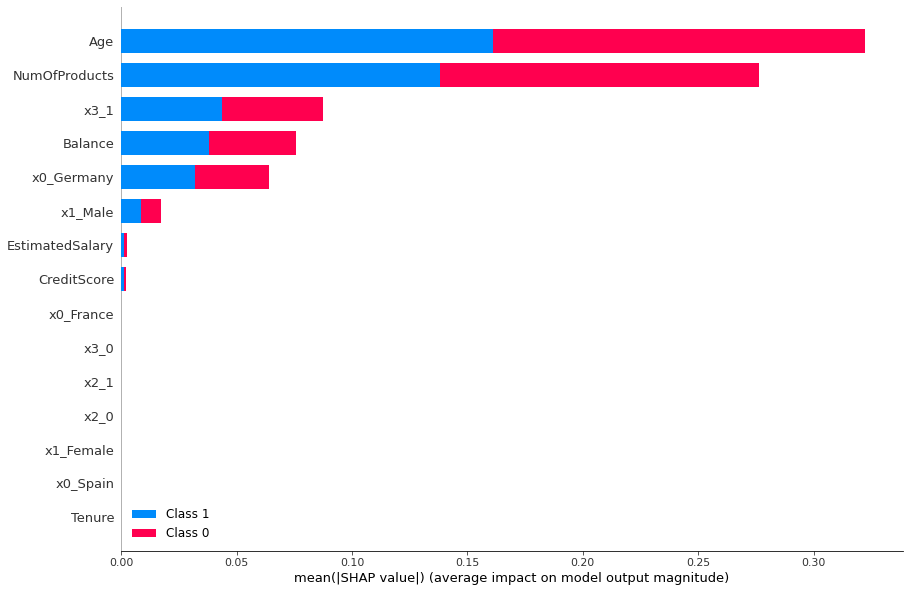

In [7]:
features = cfg.NUMERICAL_FEATURES + list(dtree.named_steps['columntransformer'].transformers_[1][1].get_feature_names())

data = pd.DataFrame(dtree['columntransformer'].transform(test_data),
                    columns=features)

plot_feature_importance(model=dtree['decisiontreeclassifier'],
                        data=data)

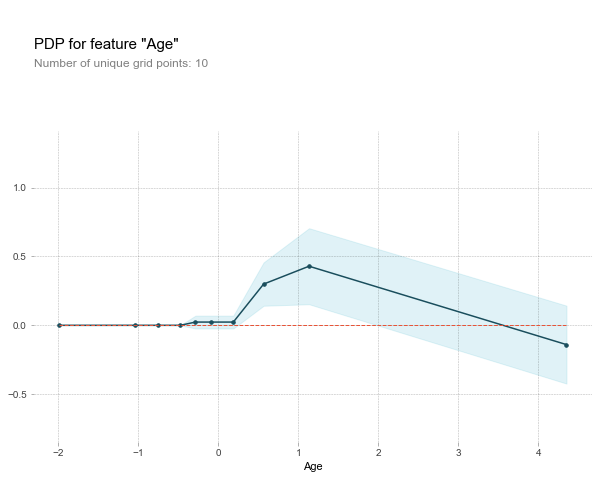

In [8]:
partial_dependence_plot(model=dtree['decisiontreeclassifier'],
                        data=data,
                        model_features=features, column='Age')

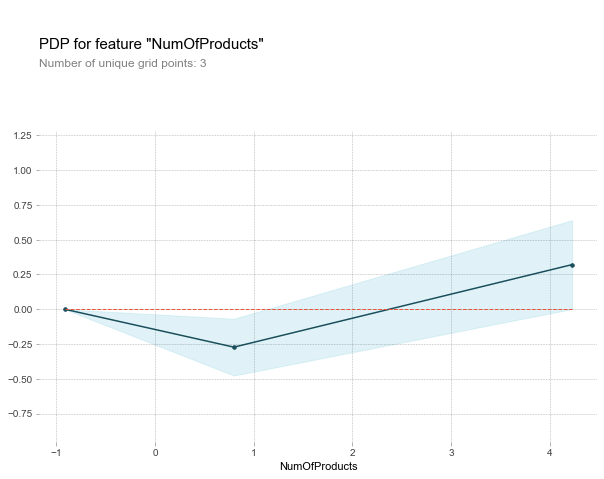

In [9]:
partial_dependence_plot(model=dtree['decisiontreeclassifier'],
                        data=data,
                        model_features=features, column='NumOfProducts')
